# Introduction to Machine Learning
  
Classifiers help us to distinguish between categories of data automatically.
  - Computer runs a 'generic' program
  - Adapts parameters to training data
  
Classification Steps:
  1. Divide the dataset in training and test set
  2. Extract features for training and test set
  3. Normalize features using training set feature statistics
  4. Train classifier on training set
  5. Find classifier accuracy on test set
  6. Adjust classifier settings and go back to Step 4

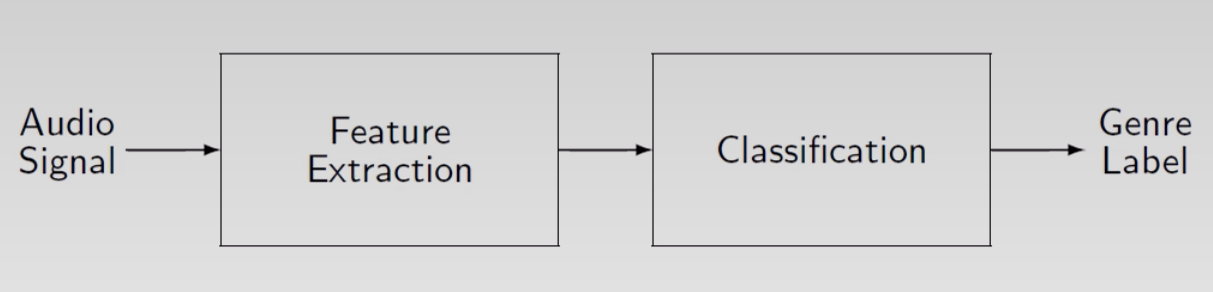

In [1]:
from IPython.display import Image
Image(filename = "img/ClassificationBlocks.png", width = 600, height = 200) 
# Image source [3]

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import pyACA   # Successful import after cloning repo in [1] and 'python setup.py install' inside the dir in terminal

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import random
import IPython.display as ipd

random.seed(10)
print(random.random())

0.5714025946899135


## Training and Test set Split
Rules of Thumb:
    - Training set size vs number of features: 
      - Training set small and number of features large -> Overfitting
      - Generally 80-20 split between training and test is good.
    - Training set too noisy -> Underfitting
    - Training set not representative -> Bad classification performance
    - Test set must not overlap with Training set. This is to simulate generalization performance of classifier on unknown dataset.

In [5]:
# Creat list of files to divide in train and test
# Genre dataset from [2]
# all labels: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
genre_labels =  ['metal', 'jazz', 'pop', 'classical']  
num_files = 100 
num_genres = len(genre_labels)
total_files = num_files * num_genres
audio_dir = 'genres'

audio_path = np.empty(total_files, dtype="<U80")
labels = np.empty(total_files, dtype="<U10")

i = 0
for label in genre_labels:
    subdir = join(audio_dir, label)
    print(subdir)
    for f in listdir(subdir):
        file_path = join(subdir, f)
        if isfile(file_path):
            audio_path[i] = file_path
            labels[i] = label
            i = i+1

genres/metal
genres/jazz
genres/pop
genres/classical


In [6]:
len(audio_path), len(labels)

(400, 400)

In [7]:
(audio_path[0], labels[0]), (audio_path[100], labels[100]), (audio_path[200], labels[200]), (audio_path[300], labels[300])

(('genres/metal/metal.00000.wav', 'metal'),
 ('genres/jazz/jazz.00000.wav', 'jazz'),
 ('genres/pop/pop.00000.wav', 'pop'),
 ('genres/classical/classical.00000.wav', 'classical'))

In [8]:
train_audio, test_audio, train_labels, test_labels = train_test_split(
    audio_path, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=11)
print(len(train_labels), "train +", len(test_labels), "test")

print("Train label counts: ", np.unique(train_labels, return_counts=True))
print("Test label counts: ", np.unique(test_labels, return_counts=True))

320 train + 80 test
Train label counts:  (array(['classical', 'jazz', 'metal', 'pop'], dtype='<U10'), array([80, 80, 80, 80]))
Test label counts:  (array(['classical', 'jazz', 'metal', 'pop'], dtype='<U10'), array([20, 20, 20, 20]))


## Extract features on training set
We will be using 4 features from the pyACA library: RMS Energy, Spectral Centroid, Spectral Flux, Spectral Rolloff  
Let us extract and visualize it for one of the audio files in the GTZAN genre dataset [2]  

### Rule of thumb for features
- Poor features -> bad classification performance
- Features *not* normalized -> possibly bad classification performance
  - Normalization: range, mean, symmetry [https://en.wikipedia.org/wiki/Feature_scaling]

In [9]:
# Extract features for 1 file
[fs, AudioData] = pyACA.ToolReadAudio(train_audio[1])
# compute features
[time_rms, t_rms] = pyACA.computeFeature("TimeRms", AudioData, fs)
[spec_centroid, t_centroid] = pyACA.computeFeature("SpectralCentroid", AudioData, fs)
[spec_flux, t_flux] = pyACA.computeFeature("SpectralFlux", AudioData, fs)
[spec_rolloff, t_rolloff] = pyACA.computeFeature("SpectralRolloff", AudioData, fs)

In [10]:
print("Audio file: ", train_audio[1])
print("Feature length for RMS: ", time_rms.shape[0], " calculated over ", len(t_rms), " windows")
print("Feature length for SpectralCentroid: ", spec_centroid.shape[0], " calculated over ", len(t_centroid), "windows")
print("Samples in audio: ", len(AudioData), " and sampling frequency ", fs)

Audio file:  genres/pop/pop.00067.wav
Feature length for RMS:  325  calculated over  325  windows
Feature length for SpectralCentroid:  324  calculated over  324 windows
Samples in audio:  661504  and sampling frequency  22050


In [11]:
time_rms.shape, spec_centroid.shape, spec_flux.shape, spec_rolloff.shape

((325,), (324,), (324,), (324,))

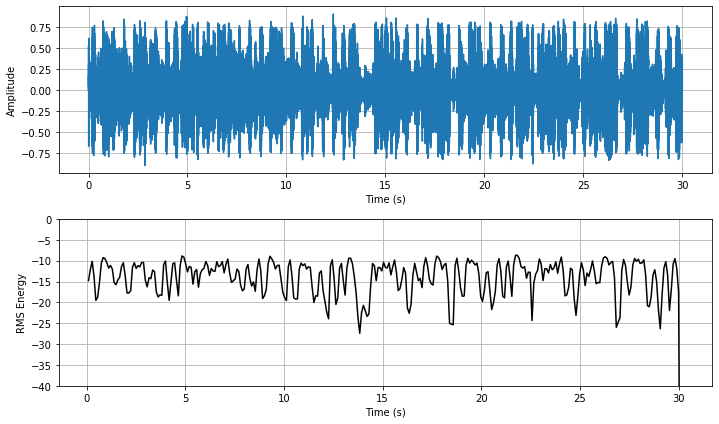

In [12]:
# visualize a feature
duration = len(AudioData)/fs
audio_t = np.linspace(0, duration, int(duration*fs), endpoint=False)

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(audio_t,AudioData)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t_rms,np.squeeze(time_rms), 'k')
plt.xlabel("Time (s)")
plt.ylabel("RMS Energy")
plt.ylim((-40,0))
plt.tight_layout()
plt.grid(True)
# lower bar -50 y-axis for RMS

In [13]:
ipd.Audio(train_audio[1])

In [14]:
np.mean(time_rms), np.mean(spec_centroid), np.mean(spec_flux), np.mean(spec_rolloff)

(-14.526021617631033,
 3976.8497273488533,
 8.256026388731358e-05,
 8245.771280924479)

In [15]:
# Extract features for Training set
train_features = np.empty((len(train_labels), 4*2))

for index, file in enumerate(train_audio):
    # read audio file
    [fs, AudioData] = pyACA.ToolReadAudio(file)
    
    # compute features
    [time_rms, t_rms] = pyACA.computeFeature("TimeRms", AudioData, fs)
    [spec_centroid, t_centroid] = pyACA.computeFeature("SpectralCentroid", AudioData, fs)
    [spec_flux, t_flux] = pyACA.computeFeature("SpectralFlux", AudioData, fs)
    [spec_rolloff, t_rolloff] = pyACA.computeFeature("SpectralRolloff", AudioData, fs)
    
    # compress features to aggregate stats
    agg_rms = [np.mean(time_rms), np.std(time_rms)]
    agg_centroid = [np.mean(spec_centroid), np.std(spec_centroid)]
    agg_flux = [np.mean(spec_flux), np.std(spec_flux)]
    agg_rolloff = [np.mean(spec_rolloff), np.std(spec_rolloff)]
    
    feature_vector = agg_rms + agg_centroid + agg_flux + agg_rolloff
    train_features[index,:] = feature_vector

In [16]:
train_features.shape

(320, 8)

In [17]:
# Extract features for Test set
test_features = np.empty((len(test_labels), 4*2))

for index, file in enumerate(test_audio):
    [fs, AudioData] = pyACA.ToolReadAudio(file)
    
    # compute features
    [time_rms, t_rms] = pyACA.computeFeature("TimeRms", AudioData, fs)
    [spec_centroid, t_centroid] = pyACA.computeFeature("SpectralCentroid", AudioData, fs)
    [spec_flux, t_flux] = pyACA.computeFeature("SpectralFlux", AudioData, fs)
    [spec_rolloff, t_rolloff] = pyACA.computeFeature("SpectralRolloff", AudioData, fs)
    
    # compress features to aggregate stats
    agg_rms = [np.mean(time_rms), np.std(time_rms)]
    agg_centroid = [np.mean(spec_centroid), np.std(spec_centroid)]
    agg_flux = [np.mean(spec_flux), np.std(spec_flux)]
    agg_rolloff = [np.mean(spec_rolloff), np.std(spec_rolloff)]
    
    feature_vector = agg_rms + agg_centroid + agg_flux + agg_rolloff 
    test_features[index,:] = feature_vector

In [18]:
test_features.shape

(80, 8)

## Feature Normalization

Standardization, or mean removal and variance scaling: Gaussian with zero mean and unit variance.  

$z_{i}= \frac{x_{i}-\bar{x}}{\sigma }$  
where  
$x_{i}$ is a data point ($x_{1}$, $x_{2}$,… $x_{n}$)  
$\bar{x}$ is the mean  
$\sigma$ is the standard deviation  

Source: 
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://en.wikipedia.org/wiki/Feature_scaling

In [19]:
scaler = preprocessing.StandardScaler().fit(train_features)
train_norm = scaler.transform(train_features)
test_norm = scaler.transform(test_features)

## Classifier
Rule of thumb for classifier
- Classifier too complex -> overfitting
- Poor classifier -> bad classification performance


## Observe results on Test set
The resultant classifier can now be applied to Test set.

Assuming that the Training and Test sets are from same data distribution, if similar classification rate is seen on the test set as compared to the training set then it can be concluded that there is no over or underfitting. 

In other words, the classifier is general enough to achieve similar result on unseen data with similar data distribution.

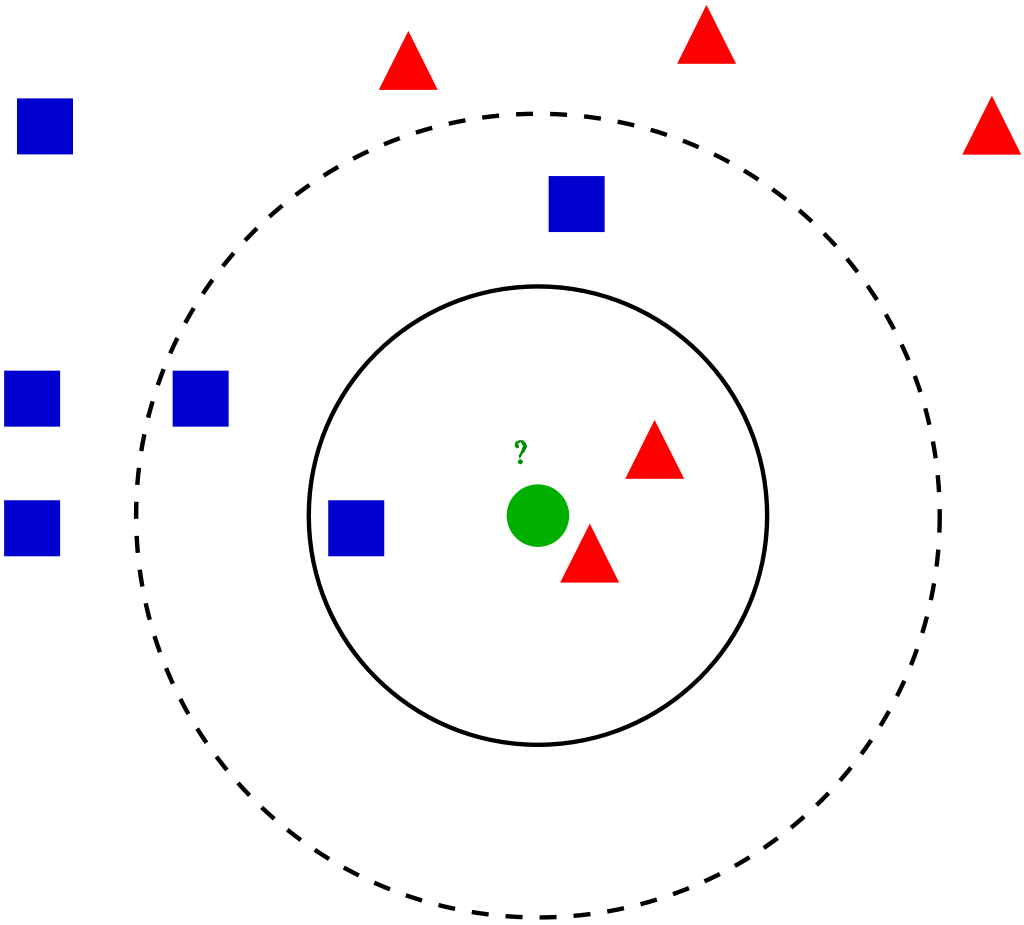

In [20]:
Image(filename = "img/KnnClassification.png", width = 400, height = 200) 
# Image source [4]

In [37]:
# Classifier functions have fit and predict functions to train and test

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_clf.fit(train_norm, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
train_knn_pred = knn_clf.predict(train_norm)
accuracy_score(train_labels, train_knn_pred)*100

89.375

In [39]:
test_knn_pred = knn_clf.predict(test_norm)
accuracy_score(test_labels, test_knn_pred)*100

83.75

In [24]:
# Confusion matrix whose i-th row and j-th column entry indicates 
# the number of samples with true label being i-th class and prediced label being j-th class.
# Accuracy = sum(diagonal elements)/len(test_labels)
print(genre_labels)
confusion_matrix(test_labels, test_knn_pred, genre_labels)

['metal', 'jazz', 'pop', 'classical']


array([[18,  1,  1,  0],
       [ 1, 16,  0,  3],
       [ 0,  2, 18,  0],
       [ 0,  4,  1, 15]])

## Feature Visualization

Install pandas and seaborn using:
- conda install pandas
- conda install seaborn

In [32]:
import seaborn as sns
import pandas as pd

<Figure size 2160x1800 with 0 Axes>

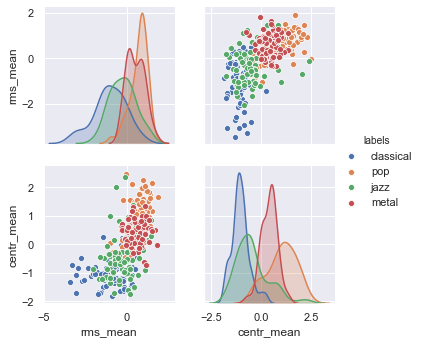

In [33]:
col = ["rms_mean", "rms_std", "centr_mean", "centr_std", "flux_mean", "flux_std", "roll_mean", "roll_std"]
train_df = pd.DataFrame(data=train_norm, columns=col)
train_df['labels'] = train_labels
plt.figure()
sns.pairplot(train_df, hue = "labels", vars=["rms_mean", "centr_mean"])
plt.show()

<Figure size 432x288 with 0 Axes>

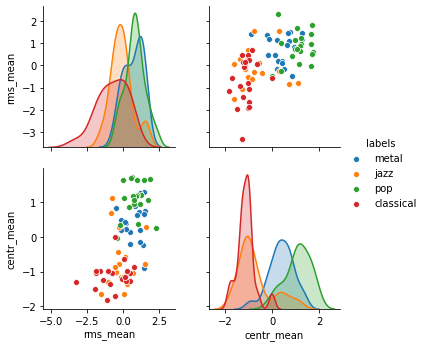

In [26]:
test_df = pd.DataFrame(data=test_norm, columns=col)
test_df['labels'] = test_labels
plt.figure(figsize=(10, 6))
sns.pairplot(test_df, hue = "labels", vars=["rms_mean", "centr_mean"])
plt.show()

## References
  [1] Feature extraction repo: https://github.com/alexanderlerch/pyACA.git
  
  [2] GTZAN dataset page: http://marsyas.info/downloads/datasets.html
  
  [3] Audio Content Analysis Slides https://github.com/alexanderlerch/ACA-Slides/blob/master/08-00-ACA-Classifiers.pdf
  
  [4] By Antti Ajanki AnAj - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2170282